In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm

from scipy import optimize

In [2]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow, LinearFlow
from nflib.coupling_flows import AffineHalfFlow, MLP_Generator, DimensionMixer
from nflib.res_flow import ResidualFlow, ReLU, LeakyReLU, Swish
##### Linear units are worst, use swish type activation
from nflib.inn_flow import iNN_Flow

In [3]:
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform

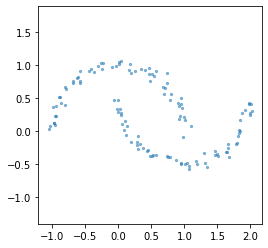

In [4]:
# Lightweight datasets
import pickle
from sklearn import datasets

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

d = DatasetMoons()
#d = DatasetMixture()
#d = DatasetSIGGRAPH()

x = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [5]:
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))

# flows = []
# hidden_dims = [24, 24, 24]
# generator = MLP_Generator([24,24,24])
# for i in range(16):
# #     a = AffineHalfFlow(dim=2, sample_dim=i%2, func_generator=generator, scale=False)
#     a = ResidualFlow(2, hidden_dims, activation=Swish, scaler=0.97, reverse=False)
#     b = ActNorm(2)
#     flows += [b, a]

flows = [iNN_Flow(2, [10, 10])]
model = NormalizingFlow(flows, prior)

In [6]:
model

NormalizingFlow(
  (flow): SequentialFlow(
    (flows): ModuleList(
      (0): iNN_Flow(
        (resblock): ModuleList(
          (0): Linear(in_features=2, out_features=10, bias=True)
          (1): Swish()
          (2): Linear(in_features=10, out_features=10, bias=True)
          (3): Swish()
          (4): Linear(in_features=10, out_features=2, bias=True)
        )
      )
    )
  )
)

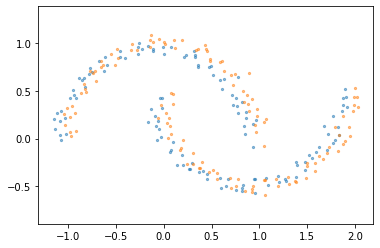

In [7]:
x = d.sample(128)
z, logDetJ = model.flow(x, True)
# z = flows[0](x)
z = z.data.detach()
plt.scatter(z[:,0], z[:,1], s=5, alpha=0.5)
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [8]:
# jpt text to stop execution

## Model Train

In [9]:
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5, betas=(0.5, 0.999)) # todo tune WD
optimizer = optim.SGD(model.parameters(), lr=0.1)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  164


In [10]:
def get_NLL(logdet, prior_log):
    y = prior_logP + logDetJ
    y.register_hook(clip_gradient_back)
    return -torch.mean(y)

def clip_gradient_back(grad):
    global model
    clipval = func_det_clipper(model.flow.flows[0].detJ)
    clipval = torch.clamp_max(clipval, 1)
    y = torch.minimum(torch.maximum(grad, -clipval), clipval)

    print("Grad orig mean, std", grad.mean(), grad.std())
    print("Grad clip mean, std", y.mean(), y.std())
    print(model.flow.flows[0].detJ.min(), clipval.min())
    print(model.flow.flows[0].detJ.max(), clipval.max())
    return y

def func_det_penalty(detJ):
    return 8*(torch.minimum(detJ-0.2, torch.Tensor([0]))**2)

def func_det_clipper(detJ):
    return 8*(torch.maximum(detJ-0.2, torch.Tensor([0]))**3)

In [11]:
class GradManager():
    
    def __init__(self, iNN):
        self.iNN = iNN
        
    def det_penalty(self):
        dp = func_det_penalty(self.iNN.detJ)
        
        ### backprop
        dp.sum().backward(retain_graph=True)
        for p in self.iNN.parameters():
            if p.grad is not None:
                p.grad_det = p.grad.detach()
                p.grad = None
            else:
                p.grad_det = None
            
    def NLL_penalty(self, logDetJ, prior_logP):
        y = prior_logP + logDetJ
        y.register_hook(self.clip_gradient_back)
        NLL = -torch.mean(y)
        NLL.backward()
        
        ### analyze the gradients now.
        for p in self.iNN.parameters():
#             print(p.grad_det)
            if p.grad_det is not None:
                mask = torch.abs(p.grad_det)>1e-5
#                 mask = ~(torch.sign(p.grad) == torch.sign(p.grad_det))
#                 print(mask)
                p.grad[mask] = p.grad_det[mask]
    #             print(mask)

        return float(NLL)
    
    def clip_gradient_back(self, grad):
        clipval = func_det_clipper(self.iNN.detJ[:len(grad)])
        clipval = torch.clamp_max(clipval, 0.1)
        y = torch.minimum(torch.maximum(grad, -clipval), clipval)
        return y

In [12]:
gm = GradManager(model.flow.flows[0])

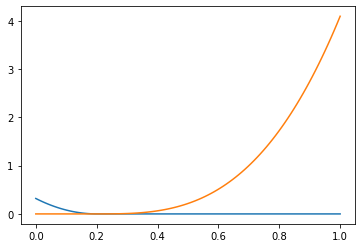

In [13]:
_x = torch.linspace(0,1, 100)
plt.plot(_x, func_det_penalty(_x))
plt.plot(_x, func_det_clipper(_x))

In [14]:
# list(gm.iNN.parameters())

In [18]:
model.train()
losses = []
for k in tqdm(range(500*2+1)):
    x = d.sample(512)
    
    rand = torch.rand(50, 2)*6-3
    x = torch.cat([x, rand], dim=0)
    
    z, logDetJ, prior_logP = model(x, True)
    
    optimizer.zero_grad()
    gm.det_penalty()
    loss = gm.NLL_penalty(logDetJ[:512], prior_logP[:512]) # NLL with hook for gradient clip
    optimizer.step()

    if k % 200 == 0:
        losses.append(loss)
        print("Loss:", k, losses[-1])
#         print("logDetJ:", logDetJ.data.min(), logDetJ.data.max())
        det = model.flow.flows[0].detJ
        print("detJ", det.data.min(), det.data.max())
        
#     break

  3%|▎         | 27/1001 [00:00<00:07, 130.06it/s]

Loss: 0 1.8818095922470093
detJ tensor(1.8446) tensor(2.5159)


 22%|██▏       | 218/1001 [00:01<00:05, 141.37it/s]

Loss: 200 1.8957648277282715
detJ tensor(1.8816) tensor(2.5265)


 42%|████▏     | 424/1001 [00:03<00:05, 115.22it/s]

Loss: 400 1.8863086700439453
detJ tensor(1.8938) tensor(2.5281)


 62%|██████▏   | 618/1001 [00:04<00:03, 121.48it/s]

Loss: 600 1.8920551538467407
detJ tensor(1.9227) tensor(2.5361)


 81%|████████  | 813/1001 [00:06<00:01, 112.03it/s]

Loss: 800 1.8932907581329346
detJ tensor(1.9321) tensor(2.5458)


100%|██████████| 1001/1001 [00:08<00:00, 118.87it/s]

Loss: 1000 1.9001402854919434
detJ tensor(1.9646) tensor(2.5545)


In [16]:
asdfsdf
z.backward(retain_graph=True)

NameError: name 'asdfsdf' is not defined

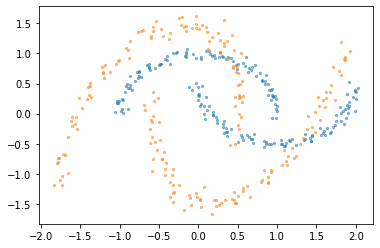

In [19]:
with torch.no_grad():
    x = d.sample(200)
    y = flows[0](x)
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.scatter(y[:,0], y[:,1], s=5, alpha=0.5)   

In [ ]:
g = lambda z: y - flows[0]._forward_no_logDetJ(z)
# find_fixed_point(g, torch.zeros_like(y))
iter_root = nflib.res_flow.broyden(g, torch.zeros_like(y), threshold=100, eps=1e-5)
_x = iter_root["result"]

print(f"Solution found in {iter_root['nstep']} steps")

plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.scatter(_x[:,0], _x[:,1], s=5, alpha=0.5)
plt.show()

In [ ]:
# g = lambda z: y - flows[0]._forward_no_logDetJ(z)
import warnings
warnings.filterwarnings(action='ignore',module='sklearn')
# from scipy.linalg import LinAlgWarning 
# warnings.filterwarnings("ignore",category= LinAlgWarning, module='sklearn')

def func_g(z, y):
    z = torch.Tensor(z)
    _x = y - flows[0]._forward_no_logDetJ(z)
    return _x.data.numpy()


methods = ["hybr", "lm", "broyden1", "broyden2", "anderson", "linearmixing",
           "diagbroyden", "excitingmixing", "krylov", "df-sane"]

### best methods broyden1,2, anderson(produces error message), excitingmixing(goodenough)
### diagbroyden, krylov produced error when not invertible. 
meth = methods[2]
print(meth)
_x = torch.empty_like(y)
for i in tqdm(range(len(y))):
    out = optimize.root(func_g, torch.zeros_like(y)[i] ,args=(y[i]), method=meth)['x']
    _x[i] = torch.Tensor(out)
    
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.scatter(_x[:,0], _x[:,1], s=5, alpha=0.5)
plt.axis([x[:,0].min()-0.1,x[:,0].max()+0.1,x[:,1].min()-0.1,x[:,1].max()+0.1])
plt.show()

In [ ]:
plt.plot(losses)

In [ ]:
model.eval()

ng = 20
xx, yy = np.linspace(-0.5, 0.5, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
x = torch.Tensor(xy)
z, logDetJ, prior_logP = model(x, True)

print(-torch.mean(prior_logP + logDetJ))
print(z.shape)

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample((128*2,))
plt.figure(figsize=(20,20))
# plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
z = z.reshape(ng, ng, -1)
for i in range(ng):
    plt.plot(z[:, i, 0], z[:, i, 1], marker='.')
for i in range(ng):
    plt.plot(z[i, :, 0], z[i, :, 1], marker='.')
    

# plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.title('x -> z')
plt.savefig("_temp.svg")

In [ ]:
# x = d.sample(128*5)
# model(x, True, True)[1]

In [ ]:
# logDetJ

In [ ]:
model.eval()

# x = d.sample(128)
x = _x.detach().numpy()
z = y.detach().numpy()
p = model.prior.sample((128*2,))
plt.figure(figsize=(7,7))
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

In [ ]:
plt.figure(figsize=(7,7))

z = model.prior.sample((128,))
__x = torch.empty_like(z)
for i in tqdm(range(len(z))):
    out = optimize.root(func_g, torch.zeros_like(z)[i] ,args=(z[i]), method=meth)['x']
    __x[i] = torch.Tensor(out)
    
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(__x[:,0], __x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')
plt.axis([z[:,0].min()-0.1,z[:,0].max()+0.1,z[:,1].min()-0.1,z[:,1].max()+0.1])

In [ ]:
# Visualize the step-wise flow in the full net
from matplotlib import collections  as mc

# plot the coordinate warp
ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3 # seems appropriate since we use radial distributions as priors
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

zs, log_dets = model.inverse(xy, True, intermediate=True)

backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
nz = len(zs)
for i in range(nz - 1):
    z0 = zs[i].detach().numpy()
    z1 = zs[i+1].detach().numpy()
    
    # plot how the samples travel at this stage
    figs, axs = plt.subplots(1, 2, figsize=(6, 3))
    #plt.figure(figsize=(20,10))
    axs[0].scatter(z0[:,0], z0[:, 1], c='r', s=3)
    axs[0].scatter(z1[:,0], z1[:, 1], c='b', s=3)
    axs[0].quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
    axs[0].axis([-3, 3, -3, 3])
    axs[0].set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
    
    q = z1.reshape((ng, ng, 2))
    # y coords
    p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # x coords
    p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # draw the lines
    axs[1].add_collection(lcy)
    axs[1].add_collection(lcx)
    axs[1].axis([-3, 3, -3, 3])
    axs[1].set_title("grid warp at the end of %d" % (i+1,))
    
    # draw the data too
    plt.scatter(x[:,0], x[:,1], c='r', s=5, alpha=0.5)

In [ ]:
dir(model.flow.flows[0].resblock[0]._forward_pre_hooks[0])

In [ ]:
model(x)